# Project - Deeplabv3+

###  1. Create data dictionary by train, valid and test

In [1]:
import pandas as pd

In [2]:
# divide data from test valid train
meta_split = pd.read_csv(f'/root/autodl-tmp/deeplabv3/archive/turtles-data/data/metadata_splits.csv')
# get main data from csv
meta_data = meta_split[['id', 'file_name', 'split_open']]
# get types name
data_type = set(meta_data['split_open'])

# get each type set and their id and file names
meta_data_dict = {}
for type in data_type:
    meta_data_dict[type] = []
for index, row in meta_data.iterrows():
    meta_data_dict[row['split_open']].append((row['id'], row['file_name']))

print(f"train set number: {len(meta_data_dict['train'])}")
print(f"valid set number: {len(meta_data_dict['valid'])}")
print(f"test set number: {len(meta_data_dict['test'])}")
meta_data 

train set number: 5303
valid set number: 1118
test set number: 2308


,id,file_name,split_open
0,1,images/t001/CAluWEgwPX.JPG,train
1,2,images/t001/EKyrFKHQzh.JPG,train
2,3,images/t001/ELAvEqeXxT.JPG,train
3,4,images/t001/IxRLFwTGCv.JPG,train
4,5,images/t001/LKCJAhfLBJ.JPG,train
...,...,...,...
8724,8725,images/t610/miUGGSioXO.jpeg,test
8725,8726,images/t610/aOzTdMCkzF.jpeg,test
8726,8727,images/t610/ZmTLXySHIZ.jpeg,test
8727,8728,images/t610/qVDYBLbzda.jpeg,test


### 2. Set class dataset by using coco

for getting image and mask, then we can put into model

In [3]:
import json
from pycocotools.coco import COCO
from pprint import pprint
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.models.segmentation
import torch.optim as optim 
import torch
import random
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
# set img dir
image_dir = '/root/autodl-tmp/deeplabv3/archive/turtles-data/data/'       

# json to coco
coco = COCO('/root/autodl-tmp/deeplabv3/archive/turtles-data/data/annotations.json')

loading annotations into memory...
Done (t=2.65s)
creating index...
index created!


In [5]:
# original transform method for image and mask
transform_method = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

target_transform_method = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST), 
    transforms.Lambda(lambda mask: torch.from_numpy(np.array(mask)).long())
])

# optim transform method for image and mask
transform = A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), 
        A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, coco, meta_data_dict, data_type, transform=None, target_transform=None):
        self.image_dir = image_dir  # original image dir
        self.coco = coco # coco
        self.data_type = data_type # train valid test
        self.transform = transform  # transform method
        self.target_transform = target_transform  # transform method
        self.images = [] # all original images path in train set

        data_list = meta_data_dict[self.data_type]
        img_Ids = self.coco.getImgIds()

        for i in img_Ids:
            # if img_id in data_type list is true
            if any(t[0] == i for t in data_list):
                self.images.append(self.coco.loadImgs(i)[0])

    def process_mask(self, image_id, image):
        category_map = {
            1: 1,  # turtles
            2: 2,  # flipper
            3: 3   # head
        }
        
        mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
        for cat_id, target_value in category_map.items():
            ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=cat_id, iscrowd=None)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                ann_mask = self.coco.annToMask(ann)
                mask[ann_mask > 0] = target_value  
                
        return mask

    def __len__(self):  # set dataset size
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        # get img id
        img_id = img['id']
        # get img path
        img_file_name = img['file_name']

        image = Image.open(f"{self.image_dir}/" + img_file_name).convert("RGB")
        mask = self.process_mask(img_id, image)
        
        if self.target_transform == None:
            augmented = self.transform(image=np.array(image, dtype=np.uint8), mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = self.transform(image)
            mask = Image.fromarray(mask.astype('uint8'))
            mask = self.target_transform(mask)

        return image, mask
    
    # image: PIL [H,W,C] -> [C,H,W]
    # mask: numpy -> PIL [H,W,C] -> [C,H,W]


### 3. Create dataset for train, valid, test

In [7]:
# create train dateset
train_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform,
    meta_data_dict=meta_data_dict,
    data_type='train'
)

# create valid dataset
valid_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform_method,
    meta_data_dict=meta_data_dict,
    target_transform=target_transform_method,
    data_type='valid'
)

# create test dataset
test_dataset = CustomDataset(
    image_dir=image_dir,
    coco=coco,
    transform=transform_method,
    meta_data_dict=meta_data_dict,
    target_transform=target_transform_method,
    data_type='test'
)

### 4. Create dataloader
divide dataset into samll dataset in order to improving effiency

In [8]:
# create valid DataLoader
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=True)
# create test DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
# create train DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### 5. Show dataloader size and dataset size

In [9]:
print("Total number of images in the train dataset:", len(train_dataset))
print("Total number of images in the valid dataset:", len(valid_dataset))
print("Total number of images in the test dataset:", len(test_dataset))
print("Total number of images in the train dataloader:", len(train_dataloader))
print("Total number of images in the valid dataloader:", len(valid_dataloader))
print("Total number of images in the test dataloader:", len(test_dataloader))

Total number of images in the train dataset: 5303
Total number of images in the valid dataset: 1118
Total number of images in the test dataset: 2308
Total number of images in the train dataloader: 332
Total number of images in the valid dataloader: 140
Total number of images in the test dataloader: 289


### 6. Show tensor shape in dataloader

In [10]:
# see the data set size
for images, masks in train_dataloader:
    print("Image min:", images.min(), "Image max:", images.max())
    print("Batch of images:", images.shape)  # show the first image tensor
    unique_values1 = torch.unique(images)  
    print("images dtype:", images.dtype)      # show the first mask dtype
    print("images value:", unique_values1)    # show the first mask uniqe
    
    print("Batch of masks:", masks.shape)    # show the first mask tensor
    unique_values = torch.unique(masks)  
    print("Masks dtype:", masks.dtype)      # show the first mask dtype
    print("Masks value:", unique_values)    # show the first mask uniqe
    break  # just want to the first one

Image min: tensor(0.) Image max: tensor(1.)
Batch of images: torch.Size([16, 3, 512, 512])
images dtype: torch.float32
images value: tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3

##### From PIL to dataset to dataloader:
- images: PIL[H, W, C] -> tensor[C, H, W] -> tensor[B, C, H, W]
- masks: PIL[H, W] -> tensor[H, W] -> tensor[B, H, W]

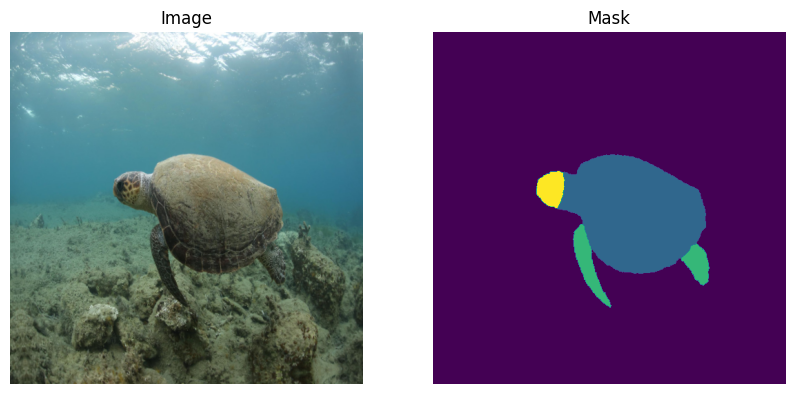

In [ ]:
import matplotlib.pyplot as plt

for images, masks in train_dataloader:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    image_np = images[0].permute(1, 2, 0).numpy()
    mask_np = masks[0].numpy()

    # 展示图像
    axs[0].imshow(image_np)
    axs[0].set_title("Image")
    axs[0].axis("off")

    # 展示掩码
    axs[1].imshow(mask_np)
    axs[1].set_title("Mask")
    axs[1].axis("off")

    plt.show()
    break 

### 7. Using deeplabv3+ model to get iou and miou

In [ ]:
num_classes = 4  # set classes number

# using deeplabv3
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",        # use resnet50 to be encoder
    encoder_weights=None,           # do not use weight
    in_channels=3,                # channels of input image
    classes=num_classes              # number of classes
)

# using cuba gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
model = model.to(device)

# loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer, learning rate 0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Using 2 GPUs


In [ ]:
torch.cuda.empty_cache()

# caculate iou function
def calculate_iou(pred_mask, true_mask, num_classes):
    ious = []
    pred_mask = pred_mask.view(-1)  
    true_mask = true_mask.view(-1)  

    for cls in range(1, num_classes):  # only caculate iou for three classes
        pred_inds = (pred_mask == cls)
        true_inds = (true_mask == cls)
        
        intersection = (pred_inds & true_inds).sum().float()  
        union = (pred_inds | true_inds).sum().float()  

        if union == 0:
            ious.append(float('nan'))  # avoid denominators of zero
        else:
            ious.append((intersection / union).item())  # append iou in list

    return ious # return list

# ----------------------
# Training Phase
# ----------------------
num_epochs = 25 # set number of epochs

for epoch in range(num_epochs):
    model.train()  # train model
    running_loss = 0.0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)  

        optimizer.zero_grad()  
        outputs = model(images)
        loss = criterion(outputs, masks.long())  
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()  # caculate loss

    # print loss
    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # ----------------------
    # Validation Phase
    # ----------------------
    model.eval()  # eval model
    all_ious = []  # record all iou in one epoch

    with torch.no_grad():  # no grad
        for images, masks in valid_dataloader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1)

            outputs = model(images)
            pred_masks = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                ious = calculate_iou(pred_masks[i], masks[i], num_classes=num_classes)
                all_ious.append(ious)

    # caculate miou and average of total miou
    all_ious_tensor = torch.tensor(all_ious)
    mean_ious = torch.nanmean(all_ious_tensor, dim=0) 
    avg_all_mious = torch.nanmean(mean_ious).item()

    # print results
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation the average of three class miou: {avg_all_mious:.4f}")
    for cls in range(num_classes):
        if cls == 0:
            print(f" - Class {cls + 1} 'turtle' mIoU: {mean_ious[cls].item():.4f}")
        elif cls == 1:
            print(f" - Class {cls + 1} 'flipper' mIoU: {mean_ious[cls].item():.4f}")
        elif cls == 2:
            print(f" - Class {cls + 1} 'head' mIoU: {mean_ious[cls].item():.4f}")
    
    print("----------------------------------------------------------------")

# save final model
torch.save(model, '/root/autodl-tmp/deeplabv3/final_model_1.pth')
print("save final_model.pth successfully")

# ----------------------
# Testing Phase
# ----------------------
model.eval()
test_ious = []

with torch.no_grad():
    for images, masks in test_dataloader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)

        outputs = model(images)
        pred_masks = torch.argmax(outputs, dim=1)

        for i in range(images.size(0)):
            ious = calculate_iou(pred_masks[i], masks[i], num_classes=num_classes)
            test_ious.append(ious)

# caculate miou and average of total miou
all_ious_tensor = torch.tensor(test_ious)
mean_ious = torch.nanmean(all_ious_tensor, dim=0)
avg_all_mious = torch.nanmean(mean_ious).item()

# print results
print(f"Testing the average of three class miou: {avg_all_mious:.4f}")
for cls in range(num_classes):
    if cls == 0:
        print(f" - Class {cls + 1} 'turtle' mIoU: {mean_ious[cls].item():.4f}")
    elif cls == 1:
        print(f" - Class {cls + 1} 'flipper' mIoU: {mean_ious[cls].item():.4f}")
    elif cls == 2:
        print(f" - Class {cls + 1} 'head' mIoU: {mean_ious[cls].item():.4f}")


/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/25], Training Loss: 0.3453
Epoch [1/25], Validation the average of three class miou: 0.3432
 - Class 1 'turtle' mIoU: 0.4897
 - Class 2 'flipper' mIoU: 0.2915
 - Class 3 'head' mIoU: 0.2485
----------------------------------------------------------------
Epoch [2/25], Training Loss: 0.1659
Epoch [2/25], Validation the average of three class miou: 0.4477
 - Class 1 'turtle' mIoU: 0.5786
 - Class 2 'flipper' mIoU: 0.4177
 - Class 3 'head' mIoU: 0.3468
----------------------------------------------------------------
Epoch [3/25], Training Loss: 0.1287
Epoch [3/25], Validation the average of three class miou: 0.5006
 - Class 1 'turtle' mIoU: 0.6557
 - Class 2 'flipper' mIoU: 0.3987
 - Class 3 'head' mIoU: 0.4474
----------------------------------------------------------------
Epoch [4/25], Training Loss: 0.1069
Epoch [4/25], Validation the average of three class miou: 0.5715
 - Class 1 'turtle' mIoU: 0.6981
 - Class 2 'flipper' mIoU: 0.5138
 - Class 3 'head' mIoU: 0.5027
---------

### 8. Show a model results randomly

In [ ]:
def load_model(model_path, device):
    model = torch.load(model_path).to(device).eval()
    return model

def get_random_sample(dataloader, device):
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)
    idx = random.randint(0, images.size(0) - 1)
    return images[idx:idx+1], masks[idx]  # return one sample

def visualize_results(image, true_mask, pred_mask):
    image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
    true_mask_np = true_mask.cpu().numpy()
    pred_mask_np = pred_mask.numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for ax, img, title in zip(axs, [image_np, true_mask_np, pred_mask_np], ["Original Image", "True Mask", "Predicted Mask"]):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.show()

In [ ]:
# set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model('/root/autodl-tmp/deeplabv3/final_model_1.pth', device)
image, true_mask = get_random_sample(test_dataloader, device)

# output predict mask
with torch.no_grad():
    output = model(image)
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu()

# visual
visualize_results(image, true_mask, pred_mask)